In [1]:
pip install graphviz numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x +5

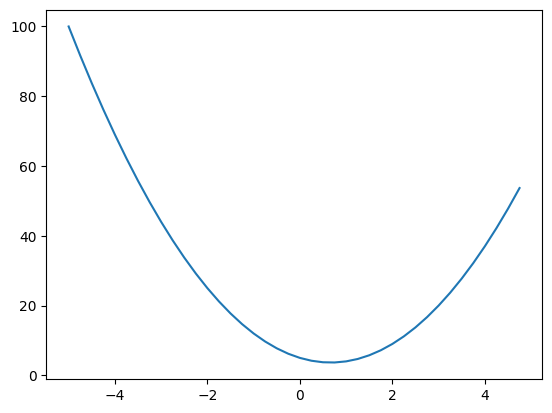

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = 2/3
(f(x+h)-f(x))/h

0.0002999999981767587

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
a += h
d2 = a*b +c

print ('d1', d1);
print ('d2', d2)
slope = (d2-d1)/h
print ('slope', slope)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label
        self._back = lambda:None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _back():
            self.grad += out.grad
            other.grad += out.grad       
            
        out._back = _back
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (other * -1.0)
    
    def __rsub__(self, other):
        return self - other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _back():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._back = _back       
        return out

    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')
        def _back(): 
            self.grad += (1 - out.data * out.data) * out.grad
        out._back = _back  
        return out
        
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _back(): 
            self.grad += out.data * out.grad
        out._back = _back  

        return out
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int or float supported"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _back():
           self.grad += other * (self.data**(other-1)) * out.grad
        out._back = _back
        return out
    
    def back(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._back()


In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | %.2f | %.2f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

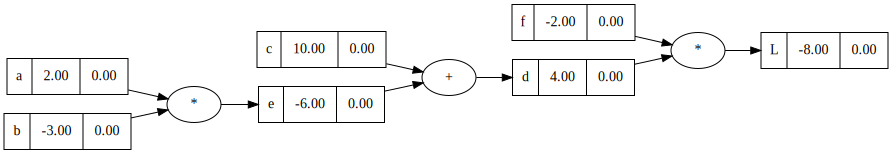

In [10]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label= 'c')
e = a*b; e.label='e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
draw_dot(L)

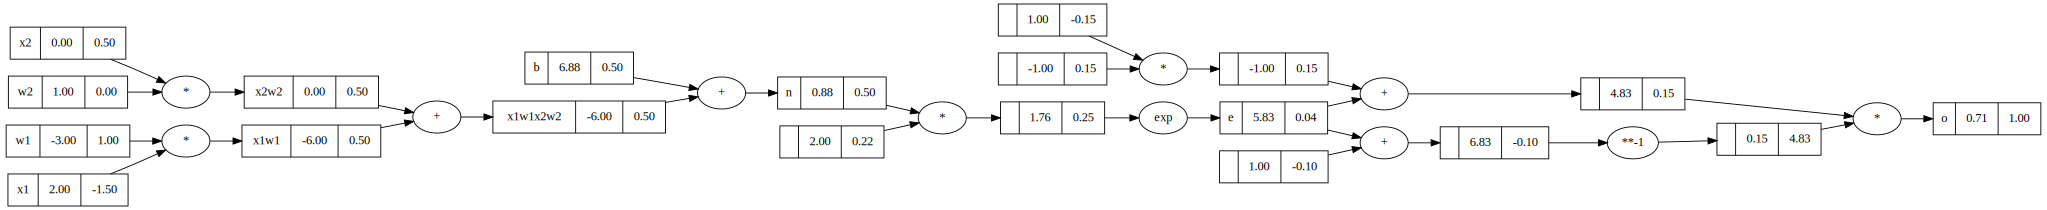

In [11]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b  = Value(6.881373587, label='b')
# n = x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp(); e.label = 'e'
o = (e-1.0) / (e+1.0); o.label = 'o'
# ----
o.grad = 1
o.back()

draw_dot(o)

In [12]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
X2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

ModuleNotFoundError: No module named 'torch'

In [48]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range (len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [109]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6334968305231226)

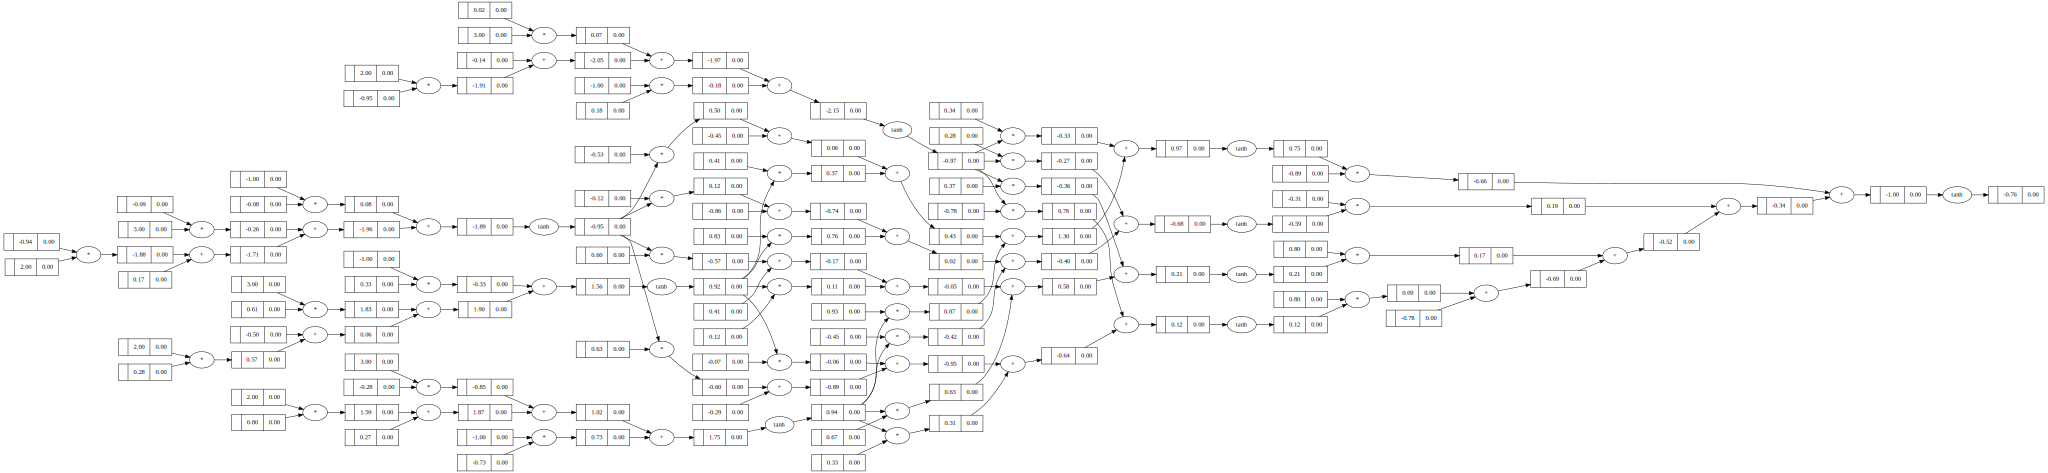

In [40]:
draw_dot(n(x))

In [110]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0, 0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

In [112]:
for k in range(2000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.back()
    
    # update
    for p in n.parameters():
        p.data -= 0.1 * p.grad # 0.05 is step size - grad is in directrion of higher loss - we want loer loss -> -=

    if k%100 == 99:
        print(k, loss)
    


99 Value(data=0.00023001224426821577)
199 Value(data=0.000209587521217594)
299 Value(data=0.0001924362467846289)
399 Value(data=0.00017783501108053942)
499 Value(data=0.00016525816393259476)
599 Value(data=0.00015431471712438574)
699 Value(data=0.0001447079171906601)
799 Value(data=0.00013620853397339525)
899 Value(data=0.00012863673299204033)
999 Value(data=0.0001218494808507577)
1099 Value(data=0.00011573161108214218)
1199 Value(data=0.00011018936806795511)
1299 Value(data=0.0001051456635043792)
1399 Value(data=0.00010053653848621542)
1499 Value(data=9.630848866263733e-05)
1599 Value(data=9.241641670911087e-05)
1699 Value(data=8.882204712871648e-05)
1799 Value(data=8.549268614722357e-05)
1899 Value(data=8.240024222361978e-05)
1999 Value(data=7.952044551274784e-05)


In [113]:
ypred

[Value(data=0.996593291883951),
 Value(data=-0.9943991058445487),
 Value(data=-0.9964819601029116),
 Value(data=0.9950838871792117)]